# Notebook 2-1: HMM Training

In this notebook, we will cover
1. **Loading prepared data**: We will load the prepared data from the previous notebook.
2. **Configuring the HMM**: We will configure the HMM with the appropriate parameters.
3. **Training the HMM (optional)**: We will train the HMM using the prepared data.
4. **Loading a pre-trained HMM**: We will load a pre-trained HMM for inference.
5. **Inference with the HMM**: We will perform inference using the trained HMM.

## 1. Loading prepared data
Here we will load the prepared data from the previous notebook `1_prepare-data.ipynb`. Recall that the data was prepared with TDE and PCA, before a final standardisation step was applied.

In [1]:
from osl_dynamics.data import Data

data = Data("prepared_data")

Loading files:   0%|          | 0/5 [00:00<?, ?it/s]

## 2. Configuring the HMM
The HMM can be configured with the `Config` and `Model` API in the `osl_dynamics.models.hmm` module. The `Config` class is used to set up the model parameters, while the `Model` class is used to create the model object itself.

In [2]:
from osl_dynamics.models.hmm import Config, Model

config = Config(
    n_states=6,
    n_channels=data.n_channels,
    sequence_length=200,
    learn_means=False,
    learn_covariances=True,
    batch_size=128,
    learning_rate=0.01,
    n_epochs=20,
)
model = Model(config)

Once you have created the model, you can have a look at a summary of the model by calling the `Model.summary()` method.

In [3]:
model.summary()

Model: "HMM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, 200, 80)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ means               │ (6, 80)           │        480 │ data[0][0]        │
│ (VectorsLayer)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ covs                │ (6, 80, 80)       │     19,440 │ data[0][0]        │
│ (CovarianceMatrice… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ll                  │ (None, 200, 80)   │          0 │ data[0][0],       │
│ (SeparateLogLikeli… │                   │            │ means[0][0],      │
│                     │                   │            │ covs[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast (Cast)         │ (None, 200, 80)   │          0 │ ll[0][0]          │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hid_state_inf       │ [(None, 200, 80), │         42 │ cast[0][0]        │
│ (HiddenMarkovState… │ (None, 200, 6,    │            │                   │
│                     │ 6)]               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_1 (Cast)       │ (None, 200, 80)   │          0 │ hid_state_inf[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ll_loss             │ (1)               │          0 │ ll[0][0],         │
│ (SumLogLikelihoodL… │                   │            │ cast_1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 19,962 (77.98 KB)

 Trainable params: 19,482 (76.10 KB)

 Non-trainable params: 480 (1.88 KB)

### Exercise
- What do the options in the `Config` class do? Can you find the documentation for the `Config` class and figure out yourself?
- Why do you see `Non-trainable params: 480 (1.88KB)` in the summary? What does this mean?

## 3. Training the HMM (optional - might take a while, ~20 - 60s per epoch)

Now we can start training the HMM. Due to the stochastic nature of the process of training the HMM and non-convexity of the loss function, we normally initialise the model with multiple initialisations. We then continue training the model with the best performing initialisation.

Here we initialise the model by training it with 3 different initialisations, each of which is trained for 1 epoch. For the HMM, this is often enough of an initialisation to get reproducible results. `n_init` could be increased if you find a high run-to-run variability.

In [4]:
init_history = model.random_state_time_course_initialization(data, n_init=3, n_epochs=1)

2025-05-16 16:42:59 INFO osl-dynamics [inf_mod_base.py:1376:random_state_time_course_initialization]: Random state time course initialization
2025-05-16 16:42:59 INFO osl-dynamics [inf_mod_base.py:1395:random_state_time_course_initialization]: Initialization 0
2025-05-16 16:42:59 INFO osl-dynamics [inf_mod_base.py:1435:set_random_state_time_course_initialization]: Setting random means and covariances
2025-05-16 16:43:00.010188: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 704ms/step - ll_loss: 112.5480 - loss: 112.5480 - learning_rate: 0.0100 - rho: 0.2853


2025-05-16 16:43:18 INFO osl-dynamics [inf_mod_base.py:1395:random_state_time_course_initialization]: Initialization 1
2025-05-16 16:43:18 INFO osl-dynamics [inf_mod_base.py:1435:set_random_state_time_course_initialization]: Setting random means and covariances
2025-05-16 16:43:19.347012: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


23/23 ━━━━━━━━━━━━━━━━━━━━ 17s 704ms/step - ll_loss: 112.7803 - loss: 112.7803 - learning_rate: 0.0100 - rho: 0.2853


2025-05-16 16:43:36 INFO osl-dynamics [inf_mod_base.py:1395:random_state_time_course_initialization]: Initialization 2
2025-05-16 16:43:36 INFO osl-dynamics [inf_mod_base.py:1435:set_random_state_time_course_initialization]: Setting random means and covariances


23/23 ━━━━━━━━━━━━━━━━━━━━ 17s 686ms/step - ll_loss: 112.4924 - loss: 112.4924 - learning_rate: 0.0100 - rho: 0.2853


2025-05-16 16:43:54 INFO osl-dynamics [inf_mod_base.py:1421:random_state_time_course_initialization]: Using initialization 0


Now we have a good initialisation, we do the full model training by calling the `Model.fit()` method.

In [5]:
history = model.fit(data)

Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 18s 733ms/step - ll_loss: 111.7066 - loss: 111.7066 - learning_rate: 0.0100 - rho: 0.2853
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 17s 707ms/step - ll_loss: 111.5196 - loss: 111.5196 - learning_rate: 0.0090 - rho: 0.1866
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 17s 714ms/step - ll_loss: 111.5222 - loss: 111.5222 - learning_rate: 0.0082 - rho: 0.1436
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 17s 736ms/step - ll_loss: 111.3790 - loss: 111.3790 - learning_rate: 0.0074 - rho: 0.1187
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 18s 756ms/step - ll_loss: 111.2623 - loss: 111.2623 - learning_rate: 0.0067 - rho: 0.1022
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 17s 727ms/step - ll_loss: 111.3188 - loss: 111.3189 - learning_rate: 0.0061 - rho: 0.0904
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 17s 722ms/step - ll_loss: 111.1365 - loss: 111.1366 - learning_rate: 0.0055 - rho: 0.0814
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 17s 738ms/step - ll_loss: 111.1565 - loss: 111.1566 - learning_rat

After training, we can save the trained model with the `Model.save()` method.

In [6]:
import os

os.makedirs("results/model", exist_ok=True)
model.save("results/model")

The free energy is a measure of how well the model fits the data, with "regularisation" term added for measuring the complexity of the model. We can get the free energy on a dataset by calling the `Model.free_energy()` method. Here we will get the free energy on the training data and save the training history to a `.pkl` file.

In [7]:
import pickle

free_energy = model.free_energy(data)
history["free_energy"] = free_energy

pickle.dump(init_history, open("results/model/init_history.pkl", "wb"))
pickle.dump(history, open("results/model/history.pkl", "wb"))

Getting free energy:   0%|          | 0/24 [00:00<?, ?it/s]

2025-05-16 16:49:50.754271: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## 4. Loading a pretrained model
We have also supplied a pretrained model. If you have not trained the model yourself following the above steps, you can download the pretrained model by checking out the `0_get_model.ipynb` notebook.

`osl-dynamics` comes with a function to load pretrained models in the `osl_dynamics.models` module.

In [8]:
from osl_dynamics.models import load

model = load('results/model')

2025-05-16 16:49:50 INFO osl-dynamics [mod_base.py:699:load]: Loading model: results/model


## 5. Inference with the HMM
Now that we have a trained HMM, we can use it to infer useful information about the data. These include:
- The state time courses (posterior state probabilities - $\alpha$)
- The state means.
- The state covariance matrices.
- The probability transition matrix.
- The initial state probabilities.

In [9]:
import numpy as np
import os
import pickle

inf_params_dir = "results/inf_params"
os.makedirs(inf_params_dir, exist_ok=True)

alp = model.get_alpha(data)
means = model.get_means()
covs = model.get_covariances()
trans_prob = model.get_trans_prob()
initial_state_probs = model.get_initial_state_probs()

pickle.dump(alp, open(f"{inf_params_dir}/alp.pkl", "wb"))
np.save(f"{inf_params_dir}/means.npy", means)
np.save(f"{inf_params_dir}/covs.npy", covs)
np.save(f"{inf_params_dir}/trans_prob.npy", trans_prob)
np.save(f"{inf_params_dir}/initial_state_probs.npy", initial_state_probs)

Getting alpha:   0%|          | 0/5 [00:00<?, ?it/s]

## Exercise
How do you get the viterbi path?

In [10]:
viterbi_path = model.get_viterbi_path(data)

Getting Viterbi path:   0%|          | 0/5 [00:00<?, ?it/s]

2025-05-16 16:49:55.636441: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


We can plot the viterbi path of the first 8 seconds of the first session.

(<Figure size 1200x250 with 2 Axes>, [<Axes: xlabel='Time (s)'>])

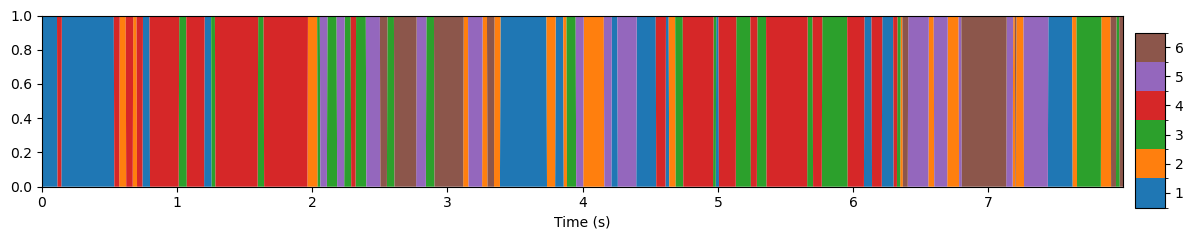

In [11]:
from osl_dynamics.utils import plotting

plotting.plot_alpha(
    viterbi_path[0],
    n_samples=2000,
    sampling_frequency=250,
)

Note: The viterbi path is the most likely sequence of hidden states given the observed data. The difference between the viterbi path and directly using the argmax of the posterior state probabilities is that the viterbi path maximises the joint posterior distribution of the entire sequence of hidden states given the observed data, while the argmax of the posterior state probabilities only maximises the marginal posterior distribution.

Normally we would use the argmax of the posterior state probabilities due to the fact that the viterbi path can be computationally expensive to calculate.